In [1]:
import os

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pylab as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
from dota_ml.data import data_url, transform_data
from dota_ml.utils import generate_grid, make_submission, plot_feature_ranking, plot_feature_ranking

In [3]:
if not os.path.exists('data/'):
    !wget $data_url -q --show-progress
    !tar -xvf data.tar.gz
else:
    print('Data already exists!')

Data already exists!


In [4]:
data_params = {
    'gold_features': True,
    'lh_features': True,
    'xp_features': True,
    'heroes_by_player': True, 
    'heroes_by_team': True,
    'events_features': True,
    'items_by_player': True,
    'items_by_team': True
}

train_df, test_df = transform_data(**data_params)

Adding 'last_gold_by_player'...
Adding 'last_gold_by_team'...
Adding 'gold_speed_by_player'...
Adding 'gold_speed_by_team'...
Adding 'max_gold_by_player'...
Adding 'max_gold_by_team'...
Adding 'last_lh_by_player'...
Adding 'last_lh_by_team'...
Adding 'lh_speed_by_player'...
Adding 'lh_speed_by_team'...
Adding 'max_lh_by_player'...
Adding 'max_lh_by_team'...
Adding 'last_xp_by_player'...
Adding 'last_xp_by_team'...
Adding 'xp_speed_by_player'...
Adding 'xp_speed_by_team'...
Adding 'max_xp_by_player'...
Adding 'max_xp_by_team'...
Adding one-hot encoding hero features by player...
Adding one-hot encoding hero features by team...
Adding 'events_features'...
Adding items features by player...
Adding items features by team...


In [38]:
X_train = train_df.drop('radiant_won', axis=1)
print('X_train.shape={}'.format(X_train.shape))

y_train = train_df['radiant_won']
print('y_train.shape={}'.format(y_train.shape))

X_test = test_df
print('X_test.shape={}'.format(X_test.shape))

X_train.shape=(24974, 2906)
y_train.shape=(24974,)
X_test.shape=(24974, 2906)


In [39]:
# from sklearn.decomposition import PCA
# pca = PCA(100)
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# X_test = pca.transform(test_df)

In [40]:
scoring = 'roc_auc'
k_folds = 3

estimator_params = {
    'n_estimators': 2,
    'max_depth': None,
    
    'verbose': 10
}

In [41]:
scores = cross_val_score(RandomForestClassifier(**estimator_params),
                        X_train, y_train,
                        cv=k_folds, scoring=scoring,
                        n_jobs=-1)

score = np.mean(scores)
print('score: {}'.format(score))

building tree 1 of 2
building tree 1 of 2
building tree 1 of 2


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 2


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 2


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 2


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(

score: 0.580901669674479


In [42]:
estimator = RandomForestClassifier(**estimator_params)
estimator.fit(X_train, y_train)

building tree 1 of 2


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 2


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2, n_jobs=1, oob_score=False, random_state=None,
            verbose=10, warm_start=False)

In [43]:
make_submission(pd.DataFrame(X_test, index=test_df.index), estimator,
                'submissions/', 'rfc', {**data_params, **estimator_params}, score)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


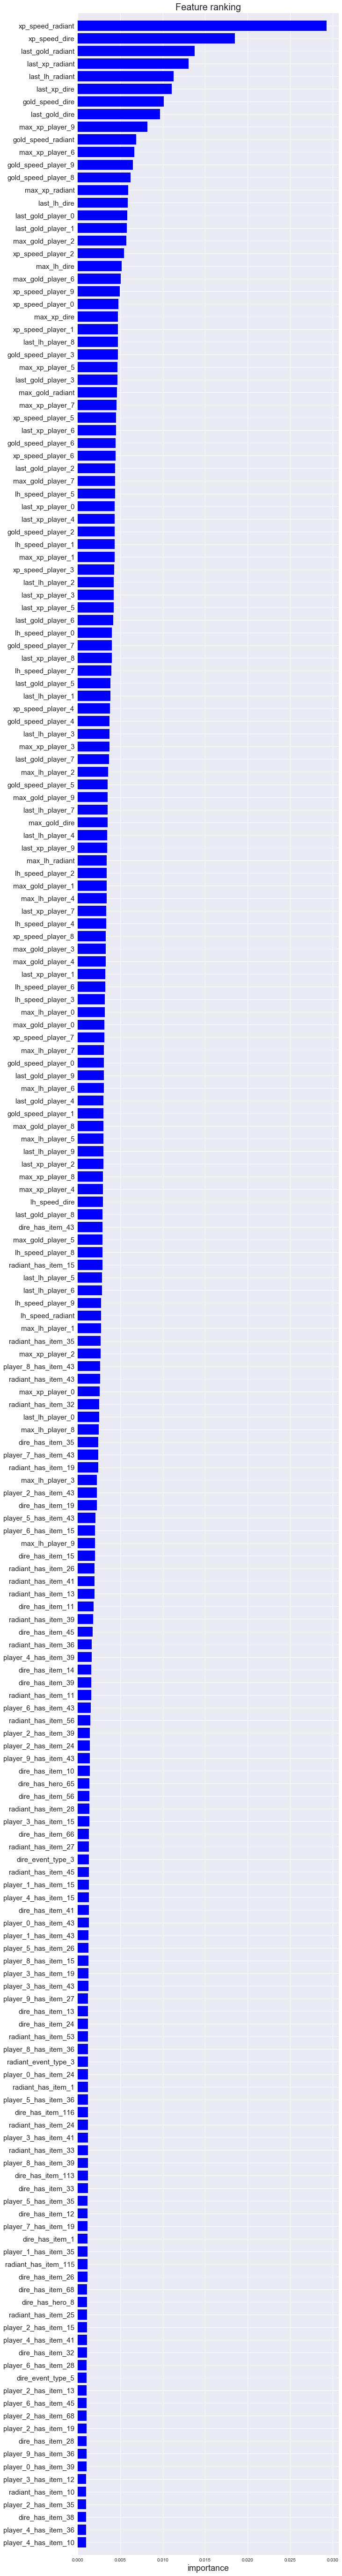

In [44]:
if hasattr(test_df, 'columns'):
    plot_feature_ranking(estimator.feature_importances_, test_df.columns, max_n_importances=200)
else:
    print('features\' column names are not avaliable')

---